## Load dependencies

In [1]:
import time
from datetime import timedelta

from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torch.optim import Adam, lr_scheduler

from unet.ml_models import UNet, UNetTunable
from unet.ml_trainer import SetupTrainer
from unet.ml_criterions import FocalTverskyLoss
from unet.ml_metrics import IoUCoeff
from unet.ml_dataset import UNetDataset, split_dataset, create_dataloaders, compute_mean_std

C:\Users\ralajan\Anaconda3\envs\unet\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Define all parameters

In [2]:
# model
IN_CHANNELS = 1
OUT_CLASSES = 1
DEPTH=4
FILTERS=3

DILATION=2
DROPOUT=True

UPMODE='upsample'

ATTENTION_BLOCK=True



# Data
VALID_SIZE = 0.2
BATCH_SIZE = 8
AUGMENT = False
# Mean and std values are calculated based
# on benchmark_version3.hdf5
# MEAN = [0.6735]
# STD = [0.1342]

MEAN = [0.67709]
STD = [0.13369]

NUM_WORKERS = 0

# Optimizer
LEARN_RATE = 0.001

# Scheduler
LR_STEP_SIZE = 10
LR_DECAY_RATE = 0.1

# Loss function
ALPHA = 0.3
BETA = 0.7
GAMMA = 0.75

# Other hyperparameters
MAX_EPOCHS = 5
EARLY_STOP_PATIENCE = 10
MIN_CKP_ACC = 0.5

NUM_SAMPLES = None  # can be used for testing
USE_CUDA = True
PATH_OUT = "experiments"
TENSORBOARD = True

## Data paths

In [3]:
png_path = "data/training_testing_set/training"

## Compute mean and std
- only if necessary

In [4]:
# mean, std = compute_mean_std(hdf5_path)
# MEAN = [mean]
# STD = [std]

## Create dataset objects

In [5]:
unet_dataset = UNetDataset.from_png_files(png_path, 
                                          augment=AUGMENT,
                                          mean=MEAN, 
                                          std=STD, 
                                          num_samples=NUM_SAMPLES)

data_dict = split_dataset(unet_dataset, VALID_SIZE)

print(data_dict["train"].__len__())
print(data_dict["valid"].__len__())

800
200


## Visualize data samples

Image shape: torch.Size([1, 80, 250])
Mask shape: torch.Size([80, 250])
Image range: [-5.064627170562744,2.4153640270233154]
Mask range: [0.0,1.0]


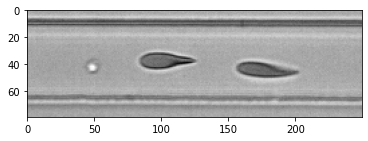

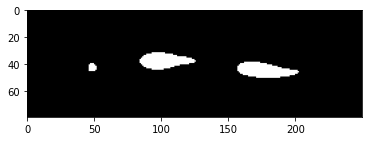

Image shape: torch.Size([1, 80, 250])
Mask shape: torch.Size([80, 250])
Image range: [-5.064627170562744,2.4153640270233154]
Mask range: [0.0,1.0]


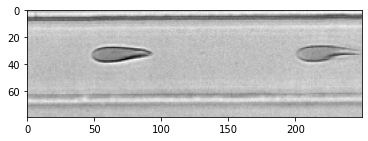

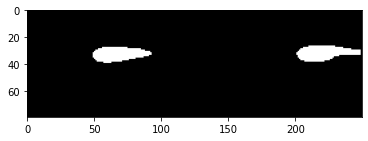

In [6]:
tds = data_dict["train"]
for i in range(2):
    img, msk = tds.__getitem__(i)
    print("Image shape:", img.shape)
    print("Mask shape:", msk.shape)
    print("Image range: [{},{}]".format(img.min(), img.max()))
    print("Mask range: [{},{}]".format(msk.min(), msk.max()))

    plt.imshow(img.permute(1, 2, 0), "gray")
    plt.show()
    plt.imshow(msk, "gray")
    plt.show()

## Create data loaders

In [7]:
dataloaders = create_dataloaders(data_dict, BATCH_SIZE, NUM_WORKERS)

In [8]:
print(len(dataloaders["train"].dataset))
print(len(dataloaders["valid"].dataset))

800
200


## Create model

In [9]:
unet_model = UNetTunable(in_channels=IN_CHANNELS,
                         out_classes=OUT_CLASSES,
                         depth=DEPTH, 
                         filters=FILTERS,
                         dilation=DILATION, 
                         dropout=DROPOUT,
                         up_mode=UPMODE,
                         with_attn=ATTENTION_BLOCK)


## Create criterion and metric

In [10]:
criterion = FocalTverskyLoss(alpha=ALPHA, beta=BETA, gamma=GAMMA)

metric = IoUCoeff()

## Create optimizer and scheduler

In [11]:
optimizer = Adam(unet_model.parameters(), lr=LEARN_RATE)

scheduler = lr_scheduler.StepLR(optimizer=optimizer,
                                step_size=LR_STEP_SIZE,
                                gamma=LR_DECAY_RATE)

## Set the trainer

In [12]:
trainer = SetupTrainer(model=unet_model,
                       dataloaders=dataloaders,
                       criterion=criterion,
                       metric=metric,
                       optimizer=optimizer,
                       scheduler=scheduler,
                       max_epochs=MAX_EPOCHS,
                       use_cuda=USE_CUDA,
                       min_ckp_acc=MIN_CKP_ACC,
                       early_stop_patience=EARLY_STOP_PATIENCE,
                       path_out=PATH_OUT,
                       tensorboard=TENSORBOARD,
                       init_from_ckp=None
                       )


Trainable parameters in the model: 119.5K


## Start Training

Started training.....
[Epochs-1/5 | lr:0.001]:
[Train_loss:0.8070 | Train_acc:0.0084 | Val_loss:0.7474 | Val_acc:0.0075]
[Epochs-2/5 | lr:0.001]:
[Train_loss:0.6815 | Train_acc:0.0205 | Val_loss:0.5893 | Val_acc:0.0645]
[Epochs-3/5 | lr:0.001]:
[Train_loss:0.4635 | Train_acc:0.3195 | Val_loss:0.2808 | Val_acc:0.7085]
[Epochs-4/5 | lr:0.001]:
[Train_loss:0.2282 | Train_acc:0.7576 | Val_loss:0.1604 | Val_acc:0.8220]
[Epochs-5/5 | lr:0.001]:
[Train_loss:0.1343 | Train_acc:0.8304 | Val_loss:0.1102 | Val_acc:0.8035]
Total training time: 0:00:24


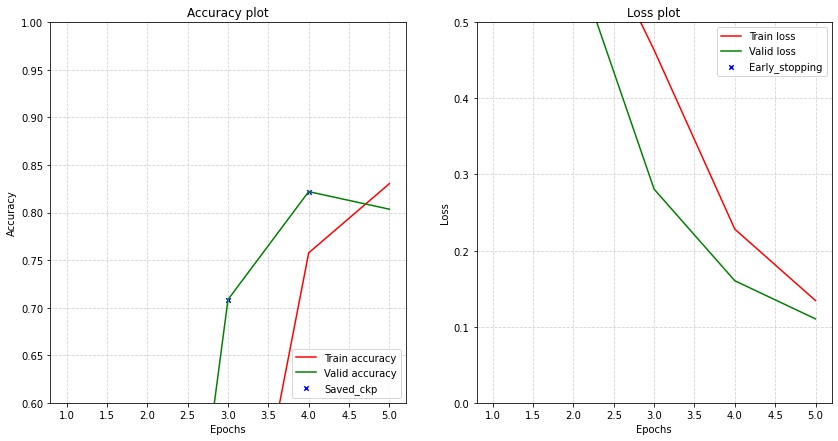

In [13]:
tik = time.time()
print("Started training.....")
trainer.start_train()
tok = time.time() - tik
train_time = str(timedelta(seconds=tok)).split('.')[0]
print(f"Total training time: {train_time}")